Predict demand by removing seasonality. This provides better accuracy than the naive prediction.

In [1]:
import pandas as pd
import os

PATH_CSV = '/kaggle/input/demand-forecasting-with-tabular-textual-images/beach_demand_forecast/'

df_sales_train = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))

df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce') 

Begin by producing a line graph of all sales over the provided 3-year timespan.

In [2]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## Detrending

Can you see an overall trend in this data? Beyond just the seasonality?

In [3]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [4]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## De-Seasoning

Lets remove the seasonality.

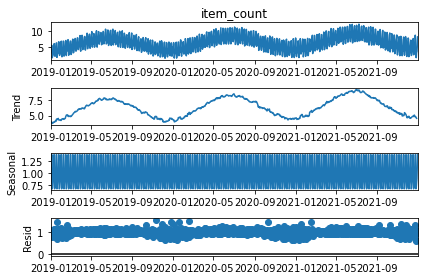

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean()

# extrapolate_trend='freq',
adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative') # , model='additive', period=7

# multiplicative
# additive

adjustment.plot()
pyplot.show()

Notice how the yearly seasonality was detected as the trend? The weekly seasonality was detected as seasonal. Without zooming you cannot see the ups and downs of the individual days of the week.

In [6]:
adjustment.trend

date
2019-01-01         NaN
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    3.920000
2019-01-05    3.672857
                ...   
2021-12-27    4.610000
2021-12-28    4.537143
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: trend, Length: 1096, dtype: float64

In [7]:
adjustment.seasonal

date
2019-01-01    0.787740
2019-01-02    0.884056
2019-01-03    1.186132
2019-01-04    1.390103
2019-01-05    1.389816
                ...   
2021-12-27    0.693107
2021-12-28    0.787740
2021-12-29    0.884056
2021-12-30    1.186132
2021-12-31    1.390103
Name: seasonal, Length: 1096, dtype: float64

## Resulting Dataset
Lets see the dataset "flattened".

In [8]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [9]:
df_adjustment = pd.DataFrame(adjustment.seasonal)
df_adjustment['trend'] = adjustment.trend

df_adjustment

,seasonal,trend
date,,
2019-01-01,0.787740,NaN
2019-01-02,0.884056,NaN
2019-01-03,1.186132,NaN
2019-01-04,1.390103,3.920000
2019-01-05,1.389816,3.672857
...,...,...
2021-12-27,0.693107,4.610000
2021-12-28,0.787740,4.537143
2021-12-29,0.884056,NaN


We will save the adjustment table to a binary pickle form, so we can later reload it exactly as it is. We will make use of this table during day 2.

In [10]:
df_adjustment.to_pickle("adjustment.pkl")

### Convert All Items
Now that we've estimated seasonality and trend for the average of all items, we must apply this to the individual items.

In [11]:
df_sales_adj = df_sales_train.merge(df_adjustment,right_index=True,left_on="date")
df_sales_adj.dropna(inplace=True)
df_sales_adj['adjust'] = df_sales_adj.item_count / df_sales_adj.seasonal / df_sales_adj.trend

Compare the individual item plot to the previous example with seasonality still embeded.

In [12]:
SINGLE_YEAR = 2020

df_sales_single_year = df_sales_adj[df_sales_train['date'].dt.year == SINGLE_YEAR]
df_plot = df_sales_single_year[['date','item_id','adjust']].groupby(['date','item_id']).mean().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['date','adjust','name']]
fig = px.bar(df_plot, x='date', y='adjust',color="name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## Model with Adjusted Data
Now lets model, with this mostly cleaned up data.

Utility function to create sequences.

In [13]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We will link the season and trend adjustments.

In [14]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales_adj.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','adjust','store_id','item_count','seasonal','trend']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'adjust':['mean'],'item_count':['mean'],'seasonal':['mean'],'trend':['mean']})
df_train.columns = ['item', 'store', 'date', 'adjust', 'item_count', 'seasonal', 'trend']
df_train.head()

,item,store,date,adjust,item_count,seasonal,trend
0,1,4,2019-01-04,0.0,0.0,1.390103,3.920000
1,1,4,2019-01-05,0.0,0.0,1.389816,3.672857
2,1,4,2019-01-06,0.0,0.0,0.669045,3.685714
3,1,4,2019-01-07,0.0,0.0,0.693107,3.695714
4,1,4,2019-01-08,0.0,0.0,0.787740,3.722857


Lets also engineer two features. This gives the neural network some information about what day of the week and day of the year we are in. Ideally, these are not needed with seasonality generally removed; however, if some seasonality and trend remain, maybe these two features help the neural network to overcome.

In [15]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear
df_train

,item,store,date,adjust,item_count,seasonal,trend,dow,doy
0,1,4,2019-01-04,0.0,0.0,1.390103,3.920000,4,4
1,1,4,2019-01-05,0.0,0.0,1.389816,3.672857,5,5
2,1,4,2019-01-06,0.0,0.0,0.669045,3.685714,6,6
3,1,4,2019-01-07,0.0,0.0,0.693107,3.695714,0,7
4,1,4,2019-01-08,0.0,0.0,0.787740,3.722857,1,8
...,...,...,...,...,...,...,...,...,...
108995,100,2,2021-12-24,0.0,0.0,1.390103,4.771429,4,358
108996,100,2,2021-12-25,0.0,0.0,1.389816,4.792857,5,359
108997,100,2,2021-12-26,0.0,0.0,0.669045,4.752857,6,360
108998,100,2,2021-12-27,0.0,0.0,0.693107,4.610000,0,361


Build the sequence data.

In [16]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),adjust(t-29),item_count(t-29),seasonal(t-29),trend(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),...,dow(t),doy(t),item(t+30),store(t+30),adjust(t+30),item_count(t+30),seasonal(t+30),trend(t+30),dow(t+30),doy(t+30)
29,1.0,4.0,0.0,0.0,1.390103,3.920000,4.0,4.0,1.0,4.0,...,5,33,1.0,4.0,0.0,0.0,0.693107,4.892857,0.0,63.0
30,1.0,4.0,0.0,0.0,1.389816,3.672857,5.0,5.0,1.0,4.0,...,6,34,1.0,4.0,0.0,0.0,0.787740,4.971429,1.0,64.0
31,1.0,4.0,0.0,0.0,0.669045,3.685714,6.0,6.0,1.0,4.0,...,0,35,1.0,4.0,0.0,0.0,0.884056,5.044286,2.0,65.0
32,1.0,4.0,0.0,0.0,0.693107,3.695714,0.0,7.0,1.0,4.0,...,1,36,1.0,4.0,0.0,0.0,1.186132,5.117143,3.0,66.0
33,1.0,4.0,0.0,0.0,0.787740,3.722857,1.0,8.0,1.0,4.0,...,2,37,1.0,4.0,0.0,0.0,1.390103,5.184286,4.0,67.0


Remove sequences that did not have enough data.

In [17]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
last_dow = 'dow(t-%d)' % window
last_doy = 'doy(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

We will predict with adjusted sales, and our engineered features.

In [18]:
import numpy as np
from keras.utils.np_utils import to_categorical   

def drop_column(df, col):
  columns_to_drop = [('%s(t+%d)' % (col, future_span))]
  for i in range(window, 0, -1):
      columns_to_drop += [('%s(t-%d)' % (col, i))]
  df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
  df.drop([f"{col}(t)"], axis=1, inplace=True, errors='ignore')

def cat_seq(df, col):
  return to_categorical(df[col].values)

# Label
labels_col = 'adjust(t+%d)' % future_span
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)
series.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series.drop('doy(t+%d)' % future_span, axis=1, inplace=True)

# Adjustment columns
unadjust_sales_col = 'item_count(t+%d)' % future_span
seasonal_col = 'seasonal(t+%d)' % future_span
trend_col = 'trend(t+%d)' % future_span

hold_sales = series[unadjust_sales_col]
hold_seasonal = series[seasonal_col]
hold_trend = series[trend_col]

series.drop(unadjust_sales_col, axis=1, inplace=True)
series.drop(seasonal_col, axis=1, inplace=True)
series.drop(trend_col, axis=1, inplace=True)


# Get sales sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "doy")
sales_series = series2.values

# Day of week as a categorical
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "doy")
drop_column(series2, "adjust")
dow_series = series2.values

# Get item sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "adjust")
doy_series = series2.values

# Day of year
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
x = np.concatenate([t1,t2,t3],axis=2)

Double check that all input data is of the same shape.

In [19]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(106070, 120, 1)
(106070, 120, 1)
(106070, 120, 1)


Extract the predictors (x sequences) and the label (future prediction)

In [20]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation
data = np.arange(len(x))
y = labels.values
np.random.shuffle(data)
split_pt = int(len(data) * 0.2)
x_valid = x[data[:split_pt]]
x_train = x[data[split_pt:]]
y_valid = y[data[:split_pt]]
y_train = y[data[split_pt:]]

# Also split the seasonality/trend data
y_train_actual = hold_sales.iloc[data[split_pt:]]
y_valid_actual = hold_sales.iloc[data[:split_pt]]

y_train_seasonal = hold_seasonal.iloc[data[split_pt:]]
y_valid_seasonal = hold_seasonal.iloc[data[:split_pt]]

y_train_trend = hold_trend.iloc[data[split_pt:]]
y_valid_trend = hold_trend.iloc[data[:split_pt]]

# Display results
print('Train set shape', x_train.shape)
print('Validation set shape', x_valid.shape)

Train set shape (84856, 120, 3)
Validation set shape (21214, 120, 3)


Final preparation for the x and y.

In [21]:
print('Train set shape', x_train.shape)
print('Validation set shape', y_valid.shape)

Train set shape (84856, 120, 3)
Validation set shape (21214,)


Construct the neural network.

In [22]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 64)           1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 56, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3584)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                179250    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 180,901
Trainable params: 180,901
Non-trainable params: 0
__________________________________________________

2022-12-02 03:47:57.819790: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Fit the neural network.

In [23]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(x_train, y_train, callbacks=[monitor],
    validation_data=(x_valid, y_valid), epochs=epochs, verbose=2)

2022-12-02 03:47:58.377469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
2652/2652 - 16s - loss: 5.5487 - val_loss: 2.0104
Epoch 2/500
2652/2652 - 15s - loss: 4.2411 - val_loss: 2.1326
Epoch 3/500
2652/2652 - 15s - loss: 3.9844 - val_loss: 2.5437
Epoch 4/500
2652/2652 - 14s - loss: 3.6230 - val_loss: 2.0111
Epoch 5/500
2652/2652 - 15s - loss: 3.5704 - val_loss: 1.9992
Epoch 6/500
2652/2652 - 14s - loss: 3.3670 - val_loss: 2.1044
Epoch 7/500
2652/2652 - 15s - loss: 3.3911 - val_loss: 2.3859
Epoch 8/500
2652/2652 - 15s - loss: 3.3296 - val_loss: 2.1346
Epoch 9/500
2652/2652 - 14s - loss: 3.1646 - val_loss: 1.6960
Epoch 10/500
2652/2652 - 16s - loss: 3.2497 - val_loss: 1.8699
Epoch 11/500
2652/2652 - 16s - loss: 2.9976 - val_loss: 1.8143
Epoch 12/500
2652/2652 - 18s - loss: 3.0167 - val_loss: 1.9603
Epoch 13/500
2652/2652 - 17s - loss: 2.9403 - val_loss: 2.0006
Epoch 14/500
2652/2652 - 17s - loss: 2.9264 - val_loss: 1.7174
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


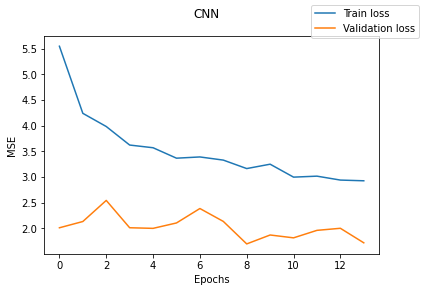

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

In [25]:
from sklearn.metrics import mean_squared_error 
import numpy as np

cnn_train_pred = model.predict(x_train) 
cnn_valid_pred = model.predict(x_valid) 
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred))) 
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_valid_pred)))

Train rmse: 1.4467201056975976
Validation rmse: 1.302296985164011


In [26]:
cnn_train_pred2 = cnn_train_pred.flatten() * y_train_seasonal * y_train_trend
cnn_valid_pred2 = cnn_valid_pred.flatten() * y_valid_seasonal * y_valid_trend

print('Train rmse:', np.sqrt(mean_squared_error(y_train_actual, cnn_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid_actual, cnn_valid_pred2)))

Train rmse: 8.908212504399478
Validation rmse: 8.373612672533152
